In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
from sklearn.metrics import r2_score

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('fivethirtyeight')

In [9]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe
       and modify the data type to reduce memory usage
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f}'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is {:.2f}'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100*(start_mem - end_mem) / start_mem))
    return df

функция reduce_mem_usage() позволит нам немного оптимизировать использование оперативной памяти загружаемым датафреймом (полезно при больших объемах данных)

In [10]:
train = reduce_mem_usage(pd.read_csv('train.csv', sep=','))

Memory usage of dataframe is 1.53
Memory usage after optimization is 0.49
Decreased by 68.1%


In [11]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250


как видно данные загружены корректно

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

признаки 4 "LifeSquare" и 15 "Healthcare_1" имеют пропущенные значения, признаки Ecology_2, Ecology_3, Shops_2 являются категориальными переменными.

In [13]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


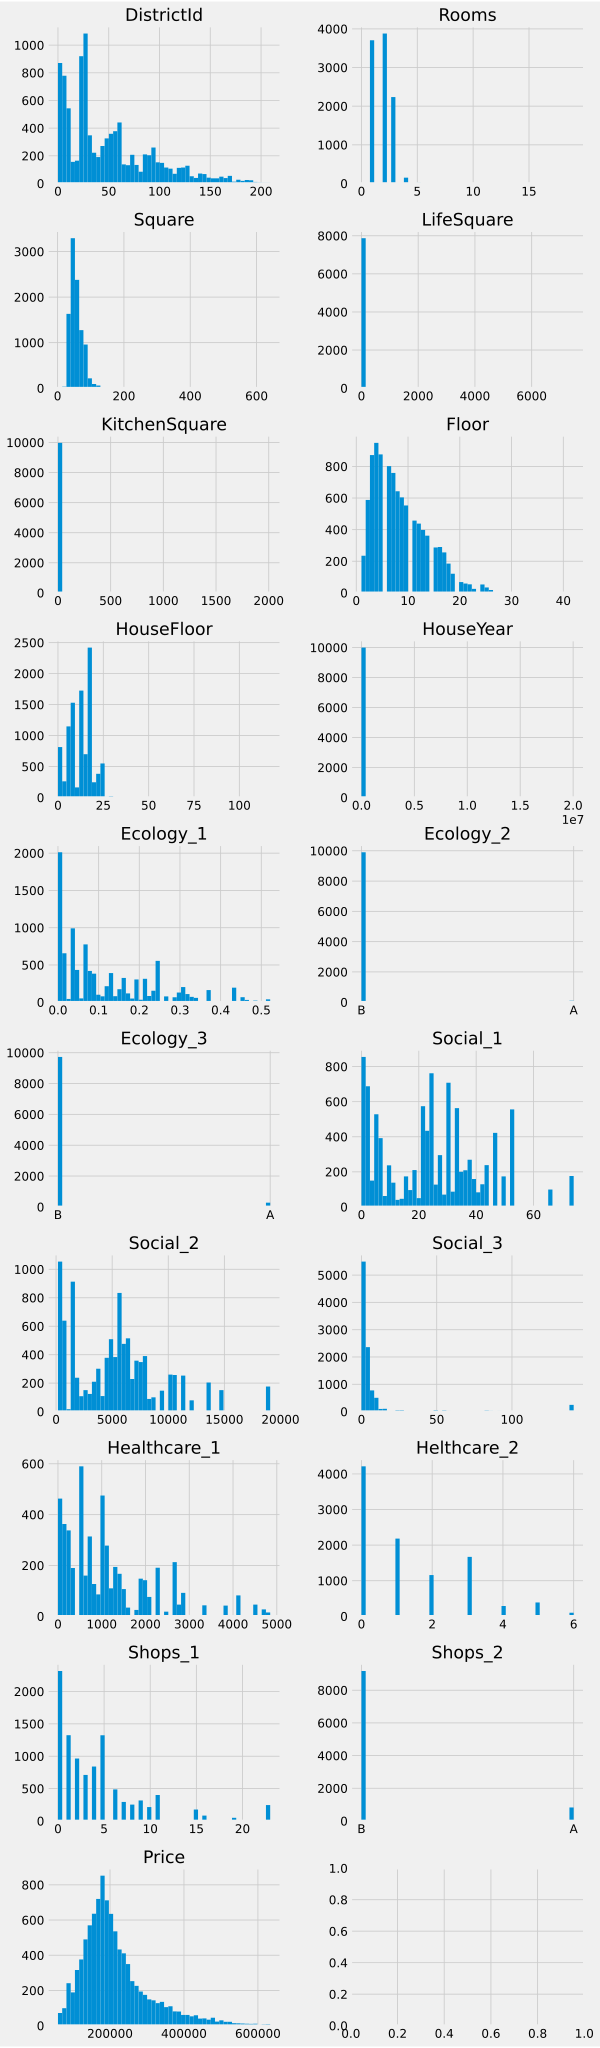

In [14]:
fig, ax = plt.subplots(nrows=10, ncols=2)
i = 0
j = 0
for feature_name in train.columns[1:]:
    ax[i, j].hist(train[feature_name], bins=50)
    ax[i, j].set_title(feature_name)
    fig.set_size_inches(10, 40)
    j += 1
    if j > 1:
        j = 0
        i += 1
plt.subplots_adjust(wspace=0.3, hspace=0.3)

из графиков по признакам Ecology_2, Ecology_3, Shops_2 видно что они обладают небольшим набором вариантов значений

In [15]:
train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

признаки принимают всего лишь два значения - заменим их на 1 и 0

In [18]:
train['Ecology_2'] = np.where((train['Ecology_2'] == 'B'), 0, 1)
train['Ecology_3'] = np.where((train['Ecology_3'] == 'B'), 0, 1)
train['Shops_2'] = np.where((train['Shops_2'] == 'B'), 0, 1)

In [19]:
train['HouseFloor'].unique()

array([  9.,  12.,  17.,   5.,   0.,   8.,   4.,  14.,  25.,   1.,  22.,
        16.,  15.,   3.,  10.,  11.,   7.,  24.,  28.,  19.,  20.,  18.,
        23.,   2.,  32.,  40.,  27.,  21.,  13.,  45.,  30.,   6.,  37.,
        48.,  47.,  44.,  39.,  36.,  29.,  99.,  38., 117.,  26.,  31.],
      dtype=float32)

ошибка - в доме не может быть 0 этажей

In [20]:
median_house_floor = train['HouseFloor'].median()
train['HouseFloor'] = np.where((train['HouseFloor'] == 0), median_house_floor, train['HouseFloor'])

In [21]:
train.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,0,0,46,7960,6,350.0,3,11,0,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,0,0,30,5562,0,NaN,0,5,1,189050.296875
9997,5123,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,0,0,2,629,1,NaN,0,0,1,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,0,1,30,5048,9,325.0,2,5,0,181595.343750
9999,6306,128,1.0,38.666645,21.157875,8.0,7,17.0,1990,0.000000,0,0,27,4798,0,30.0,2,8,0,218714.078125


по квартире с id = 77 этаж превышает максимальное число этажей в доме где она расположена

In [22]:
train['Floor'] = np.where((train['Floor'] > train['HouseFloor']), train['HouseFloor'], train['Floor'])

In [23]:
train[train['HouseYear'] > 2022]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265072,20.239714,9.0,9.0,12.0,20052011,0.136330,0,0,30,6141,10,262.0,3,6,0,254084.531250
4189,11607,147,2.0,44.791836,28.360394,5.0,4.0,9.0,4968,0.319809,0,0,25,4756,16,2857.0,5,8,0,243028.609375


из таблицы с описанием основных статистик датасета видно что максимальное значение признака HouseYear ненормальное (некорректное)

In [24]:
median_house_year = train['HouseYear'].median()
train['HouseYear'] = np.where((train['HouseYear'] > 2022), median_house_year, train['HouseYear'])

<AxesSubplot:>

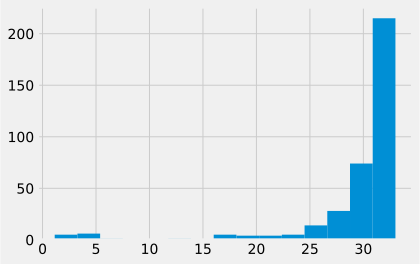

In [25]:
train[train['Square'] < 33]['Square'].hist(bins=15)

по графику видно, что аномальные значения Square до 25, предлагается исключить их из датасета

In [26]:
train = train.loc[train['Square'] >= 25]

<AxesSubplot:>

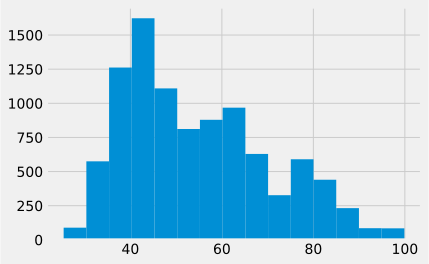

In [27]:
train[train['Square'] < 100]['Square'].hist(bins=15)

In [28]:
train[train['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427689,136.215500,0.0,3.0,3.0,2016.0,0.075424,0,0,11,3097,0,NaN,0,0,0,268394.750000
1981,7917,27,0.0,212.932358,211.231125,0.0,2.0,3.0,2008.0,0.211401,0,0,9,1892,0,NaN,0,1,0,302211.250000
2269,7317,27,0.0,41.790882,NaN,0.0,13.0,13.0,1977.0,0.211401,0,0,9,1892,0,NaN,0,1,0,98129.976562
3911,770,28,0.0,49.483501,NaN,0.0,13.0,13.0,2015.0,0.118537,0,0,30,6207,1,1183.0,1,0,0,217009.343750
4366,456,6,0.0,81.491447,NaN,0.0,4.0,13.0,1977.0,0.243205,0,0,5,1564,0,540.0,0,0,0,212864.796875
6149,3159,88,0.0,38.697117,19.345131,9.0,9.0,16.0,1982.0,0.127376,0,0,43,8429,3,NaN,3,9,0,158998.109375
8834,9443,27,0.0,87.762619,85.125473,0.0,5.0,15.0,1977.0,0.211401,0,0,9,1892,0,NaN,0,1,0,219281.921875


аномальное количество комнат

In [29]:
median_rooms = train['Rooms'].median()
train['Rooms'] = np.where((train['Rooms'] == 0), median_rooms, train['Rooms'])

In [30]:
train[(train['LifeSquare'] + train['KitchenSquare']) > train['Square']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977.0,0.437885,0,0,23,5735,3,1084.0,0,5,0,175616.234375
28,8054,23,1.0,42.530045,43.967758,1.0,3.0,9.0,2014.0,0.034656,0,0,0,168,0,NaN,0,0,0,95338.195312
44,10521,38,3.0,104.211395,106.340401,0.0,13.0,13.0,2017.0,0.060753,0,0,15,2787,2,520.0,0,7,0,435462.062500
48,7596,23,1.0,47.080101,46.807991,12.0,3.0,9.0,1977.0,0.014073,0,0,2,475,0,NaN,0,0,0,96029.164062
52,2301,1,2.0,61.400055,65.224602,0.0,17.0,22.0,2016.0,0.007122,0,0,1,264,0,NaN,0,1,0,199215.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,4497,1,1.0,38.330353,38.010048,8.0,7.0,17.0,1991.0,0.025609,0,0,33,5261,0,240.0,3,1,0,97464.328125
9902,14001,73,1.0,44.098766,44.267551,1.0,7.0,24.0,2014.0,0.042032,0,0,37,6856,84,1940.0,2,5,0,381937.406250
9910,16568,27,4.0,200.334534,201.627365,25.0,1.0,2.0,2013.0,0.041116,0,0,53,14892,4,NaN,1,4,0,528560.500000
9918,14904,34,4.0,104.049133,99.788383,10.0,8.0,25.0,2018.0,0.069753,0,0,53,13670,4,NaN,1,11,0,411971.093750


<AxesSubplot:>

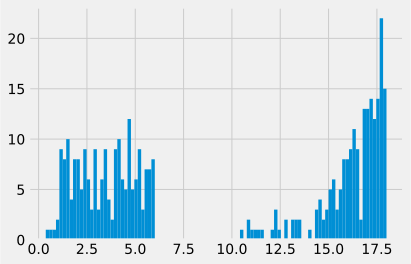

In [31]:
train[train['LifeSquare'] < 18]['LifeSquare'].hist(bins=100)

неверные значения LifeSquare предлагается обнулить, затем заполнить все пропуски путем обучения модели линейной регрессии на имеющемся наборе данных

In [32]:
train['LifeSquare'] = np.where(((train['LifeSquare'] + train['KitchenSquare']) > train['Square']), 0, train['LifeSquare'])
train['LifeSquare'] = np.where((train['LifeSquare'] < 18), 0, train['LifeSquare'])
train['LifeSquare'].fillna(0, inplace=True)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9966 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9966 non-null   int16  
 1   DistrictId     9966 non-null   int16  
 2   Rooms          9966 non-null   float32
 3   Square         9966 non-null   float32
 4   LifeSquare     9966 non-null   float32
 5   KitchenSquare  9966 non-null   float32
 6   Floor          9966 non-null   float32
 7   HouseFloor     9966 non-null   float32
 8   HouseYear      9966 non-null   float64
 9   Ecology_1      9966 non-null   float32
 10  Ecology_2      9966 non-null   int32  
 11  Ecology_3      9966 non-null   int32  
 12  Social_1       9966 non-null   int8   
 13  Social_2       9966 non-null   int16  
 14  Social_3       9966 non-null   int16  
 15  Healthcare_1   5184 non-null   float32
 16  Helthcare_2    9966 non-null   int8   
 17  Shops_1        9966 non-null   int8   
 18  Shops_2 

In [34]:
model_life_square = LinearRegression()
train_life_square = train.loc[train['LifeSquare'] != 0].copy()
test_life_square = train.loc[train['LifeSquare'] == 0].copy()

In [35]:
X_train = train_life_square.drop(columns=['Id','LifeSquare', 'KitchenSquare','Healthcare_1', 'Price'], axis=1, inplace=False)
y_train = train_life_square['LifeSquare']
X_test = test_life_square.drop(columns=['Id','LifeSquare', 'KitchenSquare', 'Healthcare_1', 'Price'], axis=1, inplace=False)
model_life_square.fit(X_train.values, y_train.values)

LinearRegression()

In [36]:
y_pred = pd.DataFrame({'LifeSquare': model_life_square.predict(X_test.values)}, index = X_test.index)
y_pred

,LifeSquare
3,33.989402
7,53.339105
8,43.746648
21,45.039485
23,78.023763
...,...
9985,26.958598
9986,43.311312
9987,39.311526
9994,43.438560


In [37]:
test_life_square['LifeSquare'] = y_pred

In [38]:
train = pd.concat([train_life_square, test_life_square], axis=0).sort_index(ascending=True)

In [39]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,9966.000000,5184.000000,9966.000000,9966.000000,9966.000000,9966.000000
mean,8380.348886,50.378989,1.894040,56.458157,36.037067,6.287377,7.929962,12.973310,1984.896649,0.118691,0.009432,0.027493,24.676901,5352.450732,8.051475,1141.512329,1.317078,4.233494,0.082581,214301.109375
std,4858.483764,43.589505,0.837657,20.946892,15.480366,28.608528,5.186591,6.438096,18.415976,0.119053,0.096665,0.163525,17.536514,4009.129337,23.870054,1021.388306,1.492649,4.810505,0.275261,92742.820312
min,0.000000,0.000000,1.000000,25.410513,12.815068,0.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4168.500000,20.000000,1.000000,41.827352,24.714327,1.000000,4.000000,9.000000,1974.000000,0.017647,0.000000,0.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,0.000000,154156.140625
50%,8390.500000,35.000000,2.000000,52.609489,32.917742,6.000000,7.000000,13.000000,1977.000000,0.075424,0.000000,0.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,0.000000,192365.859375
75%,12588.250000,75.000000,2.000000,65.937380,44.383567,9.000000,11.000000,17.000000,2001.000000,0.195781,0.000000,0.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,0.000000,249406.585938
max,16798.000000,209.000000,19.000000,641.065186,422.690074,2014.000000,42.000000,117.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.437500


In [40]:
train[train['KitchenSquare'] > train['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722244,52.219572,72.0,12.0,16.0,1987.0,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625000
551,1315,6,1.0,48.128113,32.034523,48.0,1.0,1.0,2013.0,0.243205,0,0,5,1564,0,540.0,0,0,0,146950.906250
1064,14656,62,1.0,47.100719,31.228775,2014.0,1.0,1.0,2014.0,0.072158,0,0,2,629,1,NaN,0,0,1,108337.484375
1077,9690,27,1.0,40.081043,23.498451,37.0,18.0,19.0,2019.0,0.211401,0,0,9,1892,0,NaN,0,1,0,93218.648438
1369,2371,27,2.0,68.841072,46.564716,66.0,2.0,2.0,2014.0,0.017647,0,0,2,469,0,NaN,0,0,0,189244.250000
1455,12507,54,2.0,79.810532,49.405815,78.0,10.0,15.0,2014.0,0.006076,0,0,30,5285,0,645.0,6,6,0,438708.718750
1860,4265,161,2.0,53.216778,32.038416,53.0,7.0,17.0,1994.0,0.000699,0,0,14,3369,24,4129.0,0,3,0,261125.671875
2916,12390,72,3.0,97.490677,61.414379,96.0,22.0,25.0,2019.0,0.210473,0,0,11,2398,2,1994.0,3,0,0,445074.968750
2969,7441,62,3.0,114.734474,77.741623,112.0,3.0,3.0,2015.0,0.072158,0,0,2,629,1,NaN,0,0,1,315245.531250
3379,16781,27,1.0,36.138409,22.019505,36.0,19.0,19.0,2017.0,0.072158,0,0,2,629,1,NaN,0,0,1,131742.531250


аномальные размеры KitchenSquare по отношению к LifeSquare

In [41]:
train[train['KitchenSquare'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947952,29.197611,0.0,8.0,12.0,1968.0,0.049637,0,0,34,7759,0,229.0,1,3,0,220925.906250
7,11993,74,2.0,80.312927,53.339105,0.0,13.0,13.0,1977.0,0.075779,0,0,6,1437,3,NaN,0,2,0,221244.156250
23,6641,54,3.0,118.907608,78.023763,0.0,2.0,13.0,1977.0,0.006076,0,0,30,5285,0,645.0,6,6,0,571069.062500
26,4378,27,3.0,106.958870,71.712331,0.0,13.0,13.0,2018.0,0.072158,0,0,2,629,1,NaN,0,0,1,337299.875000
39,9371,23,2.0,60.503250,41.358410,0.0,13.0,13.0,1977.0,0.034656,0,0,0,168,0,NaN,0,0,0,229778.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9948,8438,1,2.0,66.736038,45.330081,0.0,16.0,17.0,1977.0,0.007122,0,0,1,264,0,NaN,0,1,0,199237.843750
9953,5365,1,2.0,61.049492,41.493405,0.0,11.0,17.0,1977.0,0.007122,0,0,1,264,0,NaN,0,1,0,190085.171875
9960,9307,1,2.0,57.376640,36.180006,0.0,8.0,25.0,2016.0,0.007122,0,0,1,264,0,NaN,0,1,0,104450.500000
9965,6612,27,2.0,59.460686,39.086195,0.0,15.0,19.0,1977.0,0.211401,0,0,9,1892,0,NaN,0,1,0,135784.328125


<AxesSubplot:>

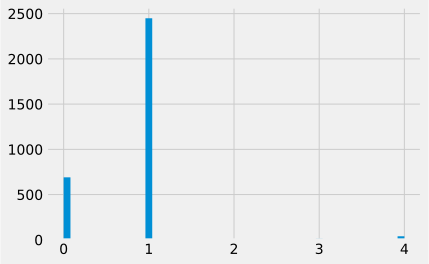

In [42]:
train[train['KitchenSquare'] < 5]['KitchenSquare'].hist(bins=50)

аномально низкие значения KitchenSquare, для решения проблемы используется тот же метод, что и в случае LifeSquare

In [43]:
train['KitchenSquare'] = np.where((train['KitchenSquare'] > train['LifeSquare']), 0, train['KitchenSquare'])
train['KitchenSquare'] = np.where((train['KitchenSquare'] < 5), 0, train['KitchenSquare'])

In [44]:
model_kitchen_square = LinearRegression()
train_kitchen_square = train.loc[train['KitchenSquare'] != 0].copy()
test_kitchen_square = train.loc[train['KitchenSquare'] == 0].copy()

In [45]:
X_train = train_kitchen_square.drop(columns=['Id', 'KitchenSquare','Healthcare_1', 'Price'], axis=1, inplace=False)
y_train = train_kitchen_square['KitchenSquare']
X_test = test_kitchen_square.drop(columns=['Id', 'KitchenSquare', 'Healthcare_1', 'Price'], axis=1, inplace=False)
model_kitchen_square.fit(X_train.values, y_train.values)

LinearRegression()

In [46]:
y_pred = pd.DataFrame({'KitchenSquare': model_kitchen_square.predict(X_test.values)}, index = X_test.index)
y_pred

,KitchenSquare
2,6.595059
7,9.437642
8,8.754555
12,7.992324
14,5.540320
...,...
9985,6.099996
9986,9.307914
9987,7.011142
9994,8.676781


In [47]:
test_kitchen_square['KitchenSquare'] = y_pred

In [48]:
train = pd.concat([train_kitchen_square, test_kitchen_square], axis=0).sort_index(ascending=True)

In [49]:
district_size = train['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId',
                                                                                 'DistrictId': 'DistrictSize'})
train = pd.merge(train, district_size, on='DistrictId', how='left')
mean_distr_size = district_size['DistrictSize'].mean()

In [50]:
median_price = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'}).rename(columns={'Price': 'MedPrice'})
train = pd.merge(train, median_price, on=['DistrictId', 'Rooms'], how='left')
median_price2 = train[train['Rooms'] == 2]['Price'].median()
train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,MedPrice
0,14038,35,2.0,47.981560,29.442751,6.000000,7.0,9.0,1969.0,0.089040,...,33,7976,5,NaN,0,11,0,184966.937500,22,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.000000,7.0,9.0,1978.0,0.000070,...,46,10309,1,240.0,1,16,0,300009.437500,86,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.595059,8.0,12.0,1968.0,0.049637,...,34,7759,0,229.0,1,3,0,220925.906250,174,263206.218750
3,5809,58,2.0,53.352982,33.989402,9.000000,8.0,17.0,1977.0,0.437885,...,23,5735,3,1084.0,0,5,0,175616.234375,179,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.000000,11.0,12.0,1976.0,0.012339,...,35,5776,1,2078.0,2,4,0,150226.531250,97,158539.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961,77,32,2.0,50.401787,30.476204,5.000000,5.0,5.0,1968.0,0.135650,...,46,7960,6,350.0,3,11,0,196684.312500,34,233599.109375
9962,6159,18,1.0,41.521545,20.539215,9.000000,13.0,13.0,2000.0,0.000000,...,30,5562,0,NaN,0,5,1,189050.296875,51,171162.187500
9963,5123,27,1.0,47.939007,30.233260,9.833330,12.0,16.0,2015.0,0.072158,...,2,629,1,NaN,0,0,1,159143.812500,847,118346.851562
9964,5400,75,2.0,43.602562,33.840149,8.000000,1.0,5.0,1961.0,0.307467,...,30,5048,9,325.0,2,5,0,181595.343750,65,187966.406250


In [51]:
median_healthcare_1 = train['Healthcare_1'].median()
train['Healthcare_1'].fillna(median_healthcare_1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9966 entries, 0 to 9965
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9966 non-null   int16  
 1   DistrictId     9966 non-null   int16  
 2   Rooms          9966 non-null   float32
 3   Square         9966 non-null   float32
 4   LifeSquare     9966 non-null   float64
 5   KitchenSquare  9966 non-null   float64
 6   Floor          9966 non-null   float32
 7   HouseFloor     9966 non-null   float32
 8   HouseYear      9966 non-null   float64
 9   Ecology_1      9966 non-null   float32
 10  Ecology_2      9966 non-null   int32  
 11  Ecology_3      9966 non-null   int32  
 12  Social_1       9966 non-null   int8   
 13  Social_2       9966 non-null   int16  
 14  Social_3       9966 non-null   int16  
 15  Healthcare_1   9966 non-null   float32
 16  Helthcare_2    9966 non-null   int8   
 17  Shops_1        9966 non-null   int8   
 18  Shops_2 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['Id', 'Price'], axis=1, inplace=False),
                                                    train['Price'], test_size=0.33, random_state=100)

In [53]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)


Number of CPUs in the system: 8


In [54]:
parameters = {'n_estimators': [100, 300, 500, 700, 900],
              'max_depth': [3, 5, 7, 10, 15]}
reg = GridSearchCV(estimator=RandomForestRegressor(random_state=100), param_grid=parameters, scoring='r2', n_jobs=n_cpu-1, cv=5)
reg.fit(X_train, y_train)
reg.best_params_

{'max_depth': 15, 'n_estimators': 900}

In [55]:
model_main = RandomForestRegressor(max_depth=15, n_estimators=900, random_state=100)
model_main.fit(X_train.values, y_train.values)

RandomForestRegressor(max_depth=15, n_estimators=900, random_state=100)

In [56]:
y_pred_tr = model_main.predict(X_train.values)

In [57]:
r2_score(y_train, y_pred_tr)

0.9520575364914349

In [58]:
y_pred = model_main.predict(X_test.values)

In [59]:
r2_score(y_test, y_pred)

0.7429478294176086

In [60]:
test = reduce_mem_usage(pd.read_csv('test.csv', sep=','))

Memory usage of dataframe is 0.72
Memory usage after optimization is 0.22
Decreased by 70.3%


In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [62]:
test['Ecology_2'] = np.where((test['Ecology_2'] == 'B'), 0, 1)
test['Ecology_3'] = np.where((test['Ecology_3'] == 'B'), 0, 1)
test['Shops_2'] = np.where((test['Shops_2'] == 'B'), 0, 1)
test['HouseFloor'] = np.where((test['HouseFloor'] == 0), median_house_floor, test['HouseFloor'])
test['Floor'] = np.where((test['Floor'] > test['HouseFloor']), test['HouseFloor'], test['Floor'])
test['HouseYear'] = np.where((test['HouseYear'] > 2022), median_house_year, test['HouseYear'])
test['Rooms'] = np.where((test['Rooms'] == 0), median_rooms, test['Rooms'])
test['LifeSquare'] = np.where(((test['LifeSquare'] + test['KitchenSquare']) > test['Square']), 0, test['LifeSquare'])
test['LifeSquare'] = np.where((test['LifeSquare'] < 18), 0, test['LifeSquare'])
test['LifeSquare'].fillna(0, inplace=True)
train_life_square = test.loc[test['LifeSquare'] != 0].copy()
test_life_square = test.loc[test['LifeSquare'] == 0].copy()
if not test_life_square.empty:
    X_test = test_life_square.drop(columns=['Id','LifeSquare', 'KitchenSquare', 'Healthcare_1'], axis=1, inplace=False)
    y_pred = pd.DataFrame({'LifeSquare': model_life_square.predict(X_test.values)}, index = X_test.index)
    test_life_square['LifeSquare'] = y_pred
    test = pd.concat([train_life_square, test_life_square], axis=0).sort_index(ascending=True)
test['KitchenSquare'] = np.where((test['KitchenSquare'] > test['LifeSquare']), 0, test['KitchenSquare'])
test['KitchenSquare'] = np.where((test['KitchenSquare'] < 5), 0, test['KitchenSquare'])
train_kitchen_square = test.loc[train['KitchenSquare'] != 0].copy()
test_kitchen_square = test.loc[train['KitchenSquare'] == 0].copy()
if not test_kitchen_square.empty:
    X_test = test_kitchen_square.drop(columns=['Id', 'KitchenSquare', 'Healthcare_1'], axis=1, inplace=False)
    y_pred = pd.DataFrame({'KitchenSquare': model_kitchen_square.predict(X_test.values)}, index = X_test.index)
    test_kitchen_square['KitchenSquare'] = y_pred
    test = pd.concat([train_kitchen_square, test_kitchen_square], axis=0).sort_index(ascending=True)
test = pd.merge(test, district_size, on='DistrictId', how='left')
test = pd.merge(test, median_price, on=['DistrictId', 'Rooms'], how='left')
test['Healthcare_1'].fillna(median_healthcare_1, inplace=True)
if not test[test['DistrictSize'].isnull()].empty:
    test['DistrictSize'].fillna(mean_distr_size, inplace=True)
if not test[test['MedPrice'].isnull()].empty:
    test['MedPrice'].fillna(median_price2, inplace=True)

In [63]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int16  
 1   DistrictId     5000 non-null   int16  
 2   Rooms          5000 non-null   float32
 3   Square         5000 non-null   float32
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float32
 6   Floor          5000 non-null   float32
 7   HouseFloor     5000 non-null   float32
 8   HouseYear      5000 non-null   float64
 9   Ecology_1      5000 non-null   float32
 10  Ecology_2      5000 non-null   int32  
 11  Ecology_3      5000 non-null   int32  
 12  Social_1       5000 non-null   int8   
 13  Social_2       5000 non-null   int16  
 14  Social_3       5000 non-null   int16  
 15  Healthcare_1   5000 non-null   float32
 16  Helthcare_2    5000 non-null   int8   
 17  Shops_1        5000 non-null   int8   
 18  Shops_2 

In [64]:
X_test = test.drop(columns=['Id'], axis=1, inplace=False)
y_pred = model_main.predict(X_test.values)
res = pd.DataFrame({'Id': test['Id'], 'Price': y_pred})

In [65]:
res

,Id,Price
0,725,162645.952388
1,15856,227278.058885
2,5480,159836.927279
3,15664,277167.124094
4,14275,146711.612104
...,...,...
4995,8180,253676.840106
4996,4695,136854.126890
4997,5783,337789.244890
4998,4780,177121.510449


In [66]:
res.to_csv('RustamIsambaev_predictions.csv', index=False, encoding='utf-8')